In [2]:
import torch
import torch.nn as nn
from torch.cuda import Event
from tools.debug.logs import RedirectOutput
import matplotlib.pyplot as plt    
import os
import contextlib
import torch.utils.benchmark
from flash_attn.ops.triton.layer_norm import layer_norm_fn
from liger_kernel.transformers.rms_norm import LigerRMSNorm

/admin/home/haojun_zhao/miniconda3/envs/nn/lib/python3.10/site-packages/flash_attn/ops/triton/layer_norm.py:959: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/admin/home/haojun_zhao/miniconda3/envs/nn/lib/python3.10/site-packages/flash_attn/ops/triton/layer_norm.py:1018: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout, *args):
/admin/home/haojun_zhao/miniconda3/envs/nn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Conclusion

**Modifications:**
- Merged QKV $\rightarrow$ Separate QKV
- Merged Gate/Up $\rightarrow$ Separate Gate/Up
- Triton RMSNorm $\rightarrow$ LLaMA RMSNorm
- Flash RoPR (training) $\rightarrow$ RoPE
- Interleaved RoPE $\rightarrow$ Non-interleaved RoPE
- Core attention $\rightarrow$ flash_attn_func
- Same computation device as transformers (CPU then CUDA)
- Fix RoPE precision bug (need to set the precision of the buffer)

**Questions:** Which one is better to keep? 

## TLDR

**Performance improvement**   
- Merged QKV and Gate_up projection only provide an improvement of less than or equal to **3%** and **0%** in TFLOPS, respectively, but they produce numerical differences         
- Triton RMSNorm provides a speedup of more than **10** times  
- Flash Rotary embedding also provides a speedup of more than **10** times    
Given batch_size = 8, and LLaMA-3 8b config, 
- Flash Rotary embedding/Triton RMSNorm saves $10^{-5}$ second for each forward, 
- Merged QKV only saves $10^{-7}$ second for each forward  

**Real bottleneck:**    
Asymptotically, FLOPs of LayerNorm is $O(d_{model})$, while there are components like the MLP that are $O(d_{model}^2)$.

With thousands times fewer FLOPs, however, the LayerNorm operation and Flash rotary embedding operation spend the same amount of time as MLP    

Given batch size = 8, sequence length = 8192    
TritonRMSNorm time: 3e-4 seconds per run, TFLOPS: 4.43   
RMSNorm time: **4e-3** seconds per run, TFLOPS: 0.38    

FlashRotaryEmbedding time: 5e-4 seconds per run   
LlamaRotaryEmbedding time: **6e-3** seconds per run   

Separate QKV time: 5e-3 seconds per run, TFLOPS: 633.62   
Merged QKV time: **5e-3** seconds per run, TFLOPS: 643.98   

# Helper function

In [30]:
# Benchmarking
def benchmark(model, *args, n_runs=100, warm_up=20, profiler_output_folder = None):
    assert next(model.parameters()).is_cuda, "Model is not on CUDA"
    assert all(param.dtype == torch.bfloat16 for param in model.parameters()), f"Model is not using {torch.bfloat16}"
    
    for _ in range(warm_up):
        _ = model(*args)
    
    # Benchmark
    start_event = Event(enable_timing=True)
    end_event = Event(enable_timing=True)
    
    torch.cuda.synchronize()
    start_event.record()
    
    if profiler_output_folder is not None:
        profiler_output_dir = os.path.join('../../.cache/profile', profiler_output_folder)
        os.makedirs(profiler_output_dir, exist_ok=True)
        profiler = torch.profiler.profile(
            activities=[
                torch.profiler.ProfilerActivity.CPU,
                torch.profiler.ProfilerActivity.CUDA,
            ],
            schedule=torch.profiler.schedule(wait=40, warmup=40, active=50, repeat=1),
            on_trace_ready=torch.profiler.tensorboard_trace_handler(profiler_output_dir),
            record_shapes=True,
            profile_memory=True,
            with_flops = True,
            with_modules=True,
            with_stack=True
        ) 
    else:
        profiler = contextlib.nullcontext()
    with profiler:
        for _ in range(n_runs):
            if isinstance(profiler, torch.profiler.profile):
                profiler.step()
            _ = model(*args)
    
    end_event.record()
    torch.cuda.synchronize()
    
    return start_event.elapsed_time(end_event) / n_runs / 1000

# def benchmark_backward(model, *args, n_runs=100, warm_up=20, profiler_output_folder = None):
#     assert next(model.parameters()).is_cuda, "Model is not on CUDA"
#     assert all(param.dtype == torch.bfloat16 for param in model.parameters()), f"Model is not using {torch.bfloat16}"
    
#     y = model(*args)
#     dy = torch.rand_like(y)
    
#     for _ in range(warm_up):
#         y.backward(dy,retain_graph=True)
    
#     # Benchmark
#     start_event = Event(enable_timing=True)
#     end_event = Event(enable_timing=True)
    
#     torch.cuda.synchronize()
#     start_event.record()
    
#     if profiler_output_folder is not None:
#         profiler_output_dir = os.path.join('../../.cache/profile', profiler_output_folder)
#         os.makedirs(profiler_output_dir, exist_ok=True)
#         profiler = torch.profiler.profile(
#             activities=[
#                 torch.profiler.ProfilerActivity.CPU,
#                 torch.profiler.ProfilerActivity.CUDA,
#             ],
#             schedule=torch.profiler.schedule(wait=40, warmup=40, active=50, repeat=1),
#             on_trace_ready=torch.profiler.tensorboard_trace_handler(profiler_output_dir),
#             record_shapes=True,
#             profile_memory=True,
#             with_flops = True,
#             with_modules=True,
#             with_stack=True
#         ) 
#     else:
#         profiler = contextlib.nullcontext()
    
#     with profiler:
#         for _ in range(n_runs):
#             if isinstance(profiler, torch.profiler.profile):
#                 profiler.step()
#             y.backward(dy,retain_graph=True)
    
#     end_event.record()
#     torch.cuda.synchronize()
    
#     return start_event.elapsed_time(end_event) / n_runs / 1000


def benchmark_forward(
    fn, *inputs, repeats=10, desc="", verbose=True, amp=False, amp_dtype=torch.bfloat16, **kwinputs
):
    """Use Pytorch Benchmark on the forward pass of an arbitrary function."""
    if verbose:
        print(desc, "- Forward pass")

    def amp_wrapper(*inputs, **kwinputs):
        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=amp):
            fn(*inputs, **kwinputs)

    t = torch.utils.benchmark.Timer(
        stmt="fn_amp(*inputs, **kwinputs)",
        globals={"fn_amp": amp_wrapper, "inputs": inputs, "kwinputs": kwinputs},
        num_threads=1,
    )
    m = t.timeit(repeats)
    if verbose:
        print(m)
    return t, m

def benchmark_backward(
    fn,
    *inputs,
    grad=None,
    repeats=10,
    desc="",
    verbose=True,
    amp=False,
    amp_dtype=torch.float16,
    **kwinputs,
):
    """Use Pytorch Benchmark on the backward pass of an arbitrary function."""
    if verbose:
        print(desc, "- Backward pass")
    # with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=amp):
    #     y = fn(*inputs, **kwinputs)
    #     if type(y) is tuple:
    #         y = y[0]
    
    y = fn(*inputs, **kwinputs)
    if type(y) is tuple:
        y = y[0]
    
    if grad is None:
        grad = torch.randn_like(y)
    else:
        if grad.shape != y.shape:
            raise RuntimeError("Grad shape does not match output shape")

    def f(*inputs, y, grad):
        # Set .grad to None to avoid extra operation of gradient accumulation
        for x in inputs:
            if isinstance(x, torch.Tensor):
                x.grad = None
        y.backward(grad, retain_graph=True)

    t = torch.utils.benchmark.Timer(
        stmt="f(*inputs, y=y, grad=grad)",
        globals={"f": f, "inputs": inputs, "y": y, "grad": grad},
        num_threads=torch.get_num_threads(),
    )
    m = t.timeit(repeats)
    if verbose:
        print(m)
    return t, m

# QKV projection

In [15]:
# Separate Q, K, V Projections
class SeparateQKV(nn.Module):
    def __init__(self, d_model, num_attention_heads, num_key_values):
        super(SeparateQKV, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.num_key_values = num_key_values
        self.d_k = d_model // num_attention_heads
        self.W_q = nn.Linear(d_model, num_attention_heads * d_k)
        self.W_k = nn.Linear(d_model, num_key_values * d_k)
        self.W_v = nn.Linear(d_model, num_key_values * d_k)

    def forward(self, x):
        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)
        return q,k,v

# Merged QKV Projection
class MergedQKV(nn.Module):
    def __init__(self, d_model, num_attention_heads, num_key_values):
        super(MergedQKV, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.num_key_values = num_key_values
        self.d_k = d_model // num_attention_heads
        self.W_qkv = nn.Linear(d_model, (num_attention_heads + 2 * num_key_values) * d_k)

    def forward(self, x):
        qkv = self.W_qkv(x)
        q, k, v = torch.split(qkv,
            [
                self.num_attention_heads * self.d_k,
                self.num_key_values * self.d_k,
                self.num_key_values * self.d_k,
            ],
            dim=-1,
        )
        return qkv

In [17]:
# Setup
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters
seven_b_llama = True
batch_size = 8
seq_len = 8192
d_model = 4096 if seven_b_llama else 8192
num_attention_heads = 32 if seven_b_llama else 64
num_key_values = 8
d_k = d_model // num_attention_heads

# Input tensor
x = torch.randn(batch_size * seq_len, d_model, dtype=torch.bfloat16, device=device)

# Initialize models
separate_qkv = SeparateQKV(d_model, num_attention_heads, num_key_values).to(device).bfloat16()
merged_qkv = MergedQKV(d_model, num_attention_heads, num_key_values).to(device).bfloat16()

# Run benchmarks
n_runs = 400

time_separate = benchmark(separate_qkv, x, n_runs=n_runs)
time_merged = benchmark(merged_qkv, x, n_runs=n_runs)

TFLOPS = 2 * batch_size * seq_len * d_model * (num_attention_heads + 2 * num_key_values) * d_k / 1e12

print(f"Separate QKV time: {time_separate:.6f} seconds per run, TFLOPS: {TFLOPS / time_separate:.2f}")
print(f"Merged QKV time: {time_merged:.6f} seconds per run, TFLOPS: {TFLOPS / time_merged:.2f}")
print(f"Speedup forward: {time_separate / time_merged:.3f}x")

Separate QKV time: 0.005102 seconds per run, TFLOPS: 646.56
Merged QKV time: 0.005020 seconds per run, TFLOPS: 657.11
Speedup forward: 1.016x


In [5]:
n_runs = 200
# time per run
seperate_qkv_t, seperate_qkv_m = benchmark_forward(separate_qkv, x, repeats=n_runs, desc="", verbose=False, amp=False, amp_dtype=torch.bfloat16)
merged_qkv_t, merged_qkv_m = benchmark_forward(merged_qkv, x, repeats=n_runs, desc="", verbose=False, amp=False, amp_dtype=torch.bfloat16)

print(seperate_qkv_m.mean)
print(merged_qkv_m.mean)
print("Speedup: ", seperate_qkv_m.mean / merged_qkv_m.mean) 

0.0051003268000204115
0.005022045209771022
Speedup:  1.0155875917040895


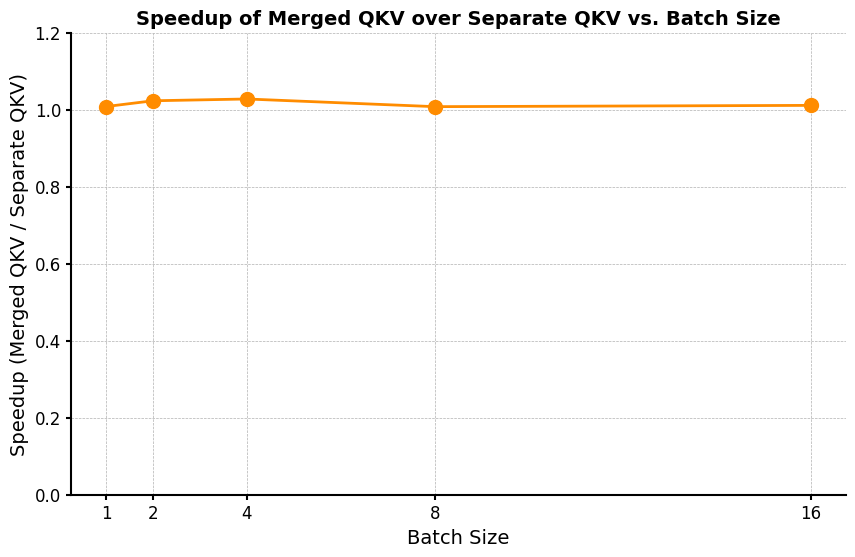

In [10]:
def benchmark_qkv(batch_sizes):
    # Setup
    torch.manual_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    seven_b_llama = True
    # Parameters
    seq_len = 8192
    d_model = 4096 if seven_b_llama else 8192
    num_attention_heads = 32 if seven_b_llama else 64
    num_key_values = 8
    d_k = d_model // num_attention_heads
    
    speedups = []

    print("Sequence length = {}, d_model = {}, num_attention_heads = {}, num_key_values = {}".format(seq_len, d_model, num_attention_heads, num_key_values))
    
    # Initialize models
    separate_qkv = SeparateQKV(d_model, num_attention_heads, num_key_values).to(device).bfloat16()
    merged_qkv = MergedQKV(d_model, num_attention_heads, num_key_values).to(device).bfloat16()
    
    for batch_size in batch_sizes:
        # Input tensor
        x = torch.randn(batch_size * seq_len, d_model, dtype=torch.bfloat16, device=device)

        # Run benchmarks
        n_runs = 600

        time_separate = benchmark(separate_qkv, x, n_runs=n_runs)
        time_merged = benchmark(merged_qkv, x, n_runs=n_runs)
        
        speedups.append(time_separate / time_merged)

        TFLOPS = 2 * batch_size * seq_len * d_model * (num_attention_heads + 2 * num_key_values) * d_k / 1e12

        print(f"batch size = {batch_size}")
        print(f"Separate QKV time: {time_separate:.6f} seconds per run, TFLOPS: {TFLOPS / time_separate:.2f}")
        print(f"Merged QKV time: {time_merged:.6f} seconds per run, TFLOPS: {TFLOPS / time_merged:.2f}")
        print(f"Speedup: {time_separate / time_merged:.2f}x")
        print(f"Time per run: {time_merged:.6f}, {time_separate:.6f}")
        print(f"Time saving per run: {(time_separate - time_merged)/n_runs:.8f} seconds")
        print()
    return speedups

batch_sizes = [1, 2, 4, 8, 16]        
with RedirectOutput("../../.cache/logs/benchmark/benchmark_qkv.txt"):
    speedups_qkv = benchmark_qkv(batch_sizes)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, speedups_qkv, marker='o', linestyle='-', color='darkorange', linewidth=2, markersize=10)
plt.xlabel('Batch Size', fontsize=14)
plt.ylabel('Speedup (Merged QKV / Separate QKV)', fontsize=14)
plt.title('Speedup of Merged QKV over Separate QKV vs. Batch Size', fontsize=14, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(batch_sizes, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1.2)

# Adding some style to the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().tick_params(width=1.5)
plt.show()    

# Gate/UP projection

In [ ]:
class SeparateGateUp(nn.Module):
    def __init__(self, d_model, intermediate_dim):
        super(SeparateGateUp, self).__init__()
        self.W_gate = nn.Linear(d_model, intermediate_dim)
        self.W_up = nn.Linear(d_model, intermediate_dim)

    def forward(self, x):
        gate = self.W_gate(x)
        up = self.W_up(x)
        return gate, up

# Merged Gate/Up Projection
class MergedGateUp(nn.Module):
    def __init__(self, d_model, intermediate_dim):
        super(MergedGateUp, self).__init__()
        self.W_gate_up = nn.Linear(d_model, intermediate_dim + intermediate_dim)
        self.intermediate_dim = intermediate_dim

    def forward(self, x):
        gate_up = self.W_gate_up(x)
        gate, up = torch.split(gate_up, [self.intermediate_dim, self.intermediate_dim], dim=-1)
        return gate, up

In [ ]:
# Separate Gate/Up Projections
intermediate_dim = 14336 

# Initialize models
separate_gate_up = SeparateGateUp(d_model, intermediate_dim).to(device).bfloat16()
merged_gate_up = MergedGateUp(d_model, intermediate_dim).to(device).bfloat16()

# Run benchmarks
n_runs = 50
time_separate = benchmark(separate_gate_up, x, n_runs=n_runs)
time_merged = benchmark(merged_gate_up, x, n_runs=n_runs)

flops = 2 * batch_size * seq_len * d_model * (intermediate_dim * 2) / 1e12

print(f"Separate Gate/Up time: {time_separate:.6f} seconds per run, TFLOPs: {(flops  / time_separate):.2f}")
print(f"Merged Gate/Up time: {time_merged:.6f} seconds per run, TFLOPs: {(flops  / time_merged):.2f}")
print(f"Speedup: {time_separate / time_merged:.2f}x")

Separate Gate/Up time: 0.023737 seconds per run, TFLOPs: 648.49
Merged Gate/Up time: 0.023896 seconds per run, TFLOPs: 644.18
Speedup: 0.99x


In [ ]:
def benchmark_gate_up(batch_sizes):
    # Setup
    torch.manual_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    seven_b_llama = True
    # Parameters
    seq_len = 8192
    d_model = 4096 if seven_b_llama else 8192
    intermediate_dim = 14336

    print("Sequence length = {}, d_model = {}, intermediate_dim = {}".format(seq_len, d_model, intermediate_dim))
    
    # Initialize models
    separate_gate_up = SeparateGateUp(d_model, intermediate_dim).to(device).bfloat16()
    merged_gate_up = MergedGateUp(d_model, intermediate_dim).to(device).bfloat16()
    
    speedups = []
    
    for batch_size in batch_sizes:
        # Input tensor
        x = torch.randn(batch_size * seq_len, d_model, dtype=torch.bfloat16, device=device)

        # Run benchmarks
        n_runs = 100

        time_separate = benchmark(separate_gate_up, x, n_runs=n_runs)
        time_merged = benchmark(merged_gate_up, x, n_runs=n_runs)
        
        speedups.append(time_separate / time_merged)

        flops = 2 * batch_size * seq_len * d_model * (intermediate_dim * 2) / 1e12

        print(f"batch size = {batch_size}")
        print(f"Separate Gate/Up time: {time_separate:.6f} seconds per run, TFLOPs: {(flops  / time_separate):.2f}")
        print(f"Merged Gate/Up time: {time_merged:.6f} seconds per run, TFLOPs: {(flops  / time_merged):.2f}")
        print(f"Speedup: {time_separate / time_merged:.2f}x")
        print(f"Time per run: {time_merged:.6f}, {time_separate:.6f}")
        print()
    return speedups
        
with RedirectOutput("../../.cache/logs/benchmark/benchmark_gate_up.txt"):
    speedups = benchmark_gate_up([1,2,4,8,16])

# Flash attention

In [6]:
from flash_attn.flash_attn_interface import flash_attn_func
import torch.nn.functional as F

causal = True

# Flash Attention
def flash_attention(q, k, v):
    # Flash Attention expects inputs in the shape (batch_size, seq_len, num_heads, head_dim)
    return flash_attn_func(q, k, v, causal=causal)

# Scaled Dot-Product Attention
def sdpa(q, k, v):
    return F.scaled_dot_product_attention(q, k, v, attn_mask=None, is_causal=causal)

In [7]:
seq_len = 8192
d_model = 4096 if seven_b_llama else 8192
num_attention_heads = 32 if seven_b_llama else 64
num_key_values = 8
d_k = d_model // num_attention_heads

q = torch.randn(batch_size, seq_len, num_attention_heads, d_k, dtype=torch.bfloat16, device=device)
k = torch.randn(batch_size, seq_len, num_key_values, d_k, dtype=torch.bfloat16, device=device)
v = torch.randn(batch_size, seq_len, num_key_values, d_k, dtype=torch.bfloat16, device=device)

n_runs = 100
time_flash = benchmark(flash_attention, q, k, v, n_runs=n_runs)

# SDPA expects inputs in the shape (batch_size, num_heads, seq_len, head_dim)
q = q.transpose(1, 2)
k = k.transpose(1, 2).repeat_interleave(num_attention_heads//num_key_values, dim=1)
v = v.transpose(1, 2).repeat_interleave(num_attention_heads//num_key_values, dim=1)

time_sdpa = benchmark(sdpa, q, k, v, n_runs=n_runs)

# Note: This FLOPS calculation is an approximation and might need adjustment
TFLOPS = 4 * batch_size * (seq_len ** 2) * num_attention_heads * d_k / 1e12 

if causal:
    TFLOPS /=2

print(f"Flash Attention time: {time_flash:.6f} seconds per run, TFLOPS: {TFLOPS / time_flash:.2f}")
print(f"SDPA time: {time_sdpa:.6f} seconds per run, TFLOPS: {TFLOPS / time_sdpa:.2f}")
print(f"Speedup: {time_sdpa / time_flash:.2f}x")

Flash Attention time: 0.012527 seconds per run, TFLOPS: 351.09
SDPA time: 0.024786 seconds per run, TFLOPS: 177.44
Speedup: 1.98x


In [9]:
def benchmark_attention(batch_sizes):
    seq_len = 8192
    d_model = 4096 if seven_b_llama else 8192
    num_attention_heads = 32 if seven_b_llama else 64
    num_key_values = 8
    d_k = d_model // num_attention_heads
    print("Sequence length = {}, d_model = {}, num_attention_heads = {}, num_key_values = {}".format(seq_len, d_model, num_attention_heads, num_key_values))
    speedups = []
    for batch_size in batch_sizes:
        q = torch.randn(batch_size, seq_len, num_attention_heads, d_k, dtype=torch.bfloat16, device=device)
        k = torch.randn(batch_size, seq_len, num_key_values, d_k, dtype=torch.bfloat16, device=device)
        v = torch.randn(batch_size, seq_len, num_key_values, d_k, dtype=torch.bfloat16, device=device)

        n_runs = 100
        time_flash = benchmark(flash_attention, q, k, v, n_runs=n_runs)

        # SDPA expects inputs in the shape (batch_size, num_heads, seq_len, head_dim)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2).repeat_interleave(num_attention_heads//num_key_values, dim=1)
        v = v.transpose(1, 2).repeat_interleave(num_attention_heads//num_key_values, dim=1)

        time_sdpa = benchmark(sdpa, q, k, v, n_runs=n_runs)

        # Note: This FLOPS calculation is an approximation and might need adjustment
        TFLOPS = 4 * batch_size * (seq_len ** 2) * num_attention_heads * d_k / 1e12

        if causal:
            TFLOPS /=2
            
        speedups.append(time_sdpa / time_flash)
        
        print(f"batch size = {batch_size}")
        print(f"Flash Attention time: {time_flash:.6f} seconds per run, TFLOPS: {TFLOPS / time_flash:.2f}")
        print(f"SDPA time: {time_sdpa:.6f} seconds per run, TFLOPS: {TFLOPS / time_sdpa:.2f}")
        print(f"Speedup: {time_sdpa / time_flash:.2f}x")
        print()
    return speedups

In [10]:
with RedirectOutput("../../.cache/logs/benchmark/benchmark_attention.txt"):
    speedup_flash = benchmark_attention([1,2,4,8,16])

# Triton RMSNorm

In [2]:
class TritonRMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-5, device=None, dtype=None):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.eps = eps
        self.weight = torch.nn.Parameter(torch.empty(hidden_size, **factory_kwargs))
        self.register_parameter("bias", None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.ones_(self.weight)

    def forward(
        self, input, residual=None, dropout_p=0.0, prenorm=False, residual_in_fp32=False, return_dropout_mask=False
    ):
        return layer_norm_fn(
            input,
            self.weight,
            None,
            residual=residual,
            eps=self.eps,
            dropout_p=dropout_p,
            prenorm=prenorm,
            residual_in_fp32=residual_in_fp32,
            is_rms_norm=True,
            return_dropout_mask=return_dropout_mask,
        )

# equivalent to TritonRMSNorm
class RMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-5):
        """
        LlamaRMSNorm is equivalent to T5LayerNorm
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, input):
        input_dtype = input.dtype
        input = input.to(torch.float32)
        variance = input.pow(2).mean(-1, keepdim=True)
        input = input * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * input.to(input_dtype)


rmsnorm-fwd-speed-benchmark:
         N     Liger  Hugging Face  flash-attention
0   1024.0  0.065792      0.616112         0.113088
1   2048.0  0.095968      1.189984         0.117600
2   4096.0  0.183840      2.328512         0.184352
3   8192.0  0.358688      4.598752         0.360032
4  16384.0  0.709984      9.140079         0.710240
5  32768.0  1.414272     18.254145         1.420480
rmsnorm-bwd-speed-benchmark:
         N     Liger  Hugging Face  flash-attention
0   1024.0  0.197872      1.613472         0.268112
1   2048.0  0.344128      3.084736         0.290880
2   4096.0  0.638048      6.047696         0.387744
3   8192.0  1.229232     11.963648         0.611520
4  16384.0  2.426496     23.814014         1.157728
5  32768.0  8.482544     47.559982         9.589584
rmsnorm-full-speed-benchmark:
         N     Liger  Hugging Face  flash-attention
0   1024.0  0.350080      2.225008         0.510144
1   2048.0  0.438976      4.277664         0.510816
2   4096.0  0.819936      8.

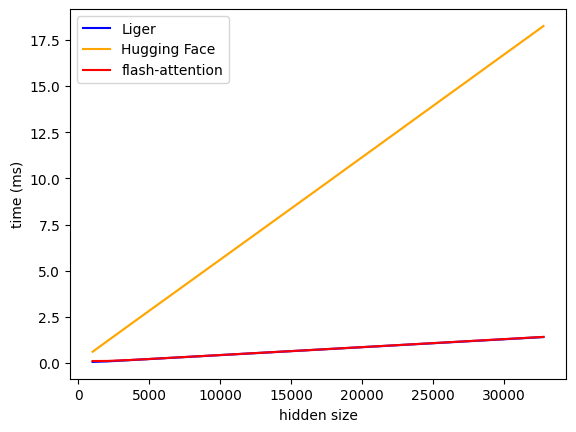

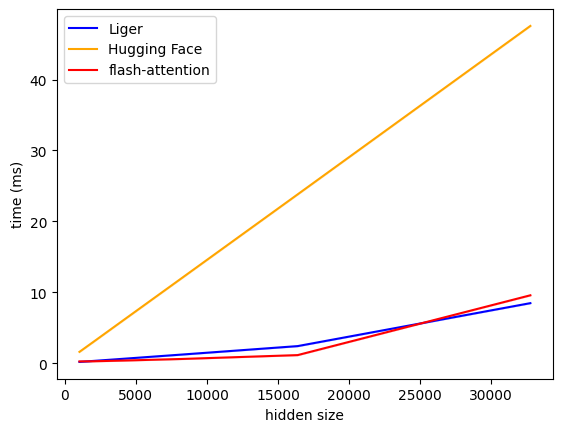

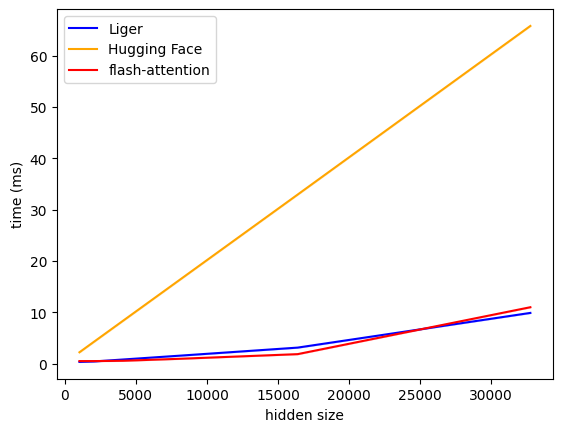

In [44]:
import triton
@triton.testing.perf_report(
    [
        triton.testing.Benchmark(
            x_names=["N"],
            x_vals=[2**i for i in range(10, 16)],
            xlabel="hidden size",
            line_arg="provider",
            line_vals=["liger", "huggingface","flash-attention"],
            line_names=["Liger", "Hugging Face", "flash-attention"],
            styles=[("blue", "solid"), ("orange", "solid"), ("red", "solid")],
            ylabel="time (ms)",
            plot_name="rmsnorm-fwd-speed-benchmark",
            args={"M": 2048, "dtype": torch.bfloat16, "mode": "forward"},
        ),
        triton.testing.Benchmark(
            x_names=["N"],
            x_vals=[2**i for i in range(10, 16)],
            xlabel="hidden size",
            line_arg="provider",
            line_vals=["liger", "huggingface","flash-attention"],
            line_names=["Liger", "Hugging Face", "flash-attention"],
            styles=[("blue", "solid"), ("orange", "solid"), ("red", "solid")],
            ylabel="time (ms)",
            plot_name="rmsnorm-bwd-speed-benchmark",
            args={"M": 2048, "dtype": torch.bfloat16, "mode": "backward"},
        ),
        triton.testing.Benchmark(
            x_names=["N"],
            x_vals=[2**i for i in range(10, 16)],
            xlabel="hidden size",
            line_arg="provider",
            line_vals=["liger", "huggingface","flash-attention"],
            line_names=["Liger", "Hugging Face", "flash-attention"],
            styles=[("blue", "solid"), ("orange", "solid"), ("red", "solid")],
            ylabel="time (ms)",
            plot_name="rmsnorm-full-speed-benchmark",
            args={"M": 2048, "dtype": torch.bfloat16, "mode": "full"},
        ),
    ]
)
def bench_speed_rms_norm(M, N, dtype, provider, mode, eps=1e-5, device="cuda"):
    x_shape = (8192*4, N)

    triton_rms = LigerRMSNorm(hidden_size=N).to("cuda")
    llama_rms = RMSNorm(hidden_size=N).to("cuda")
    triton_rmsnorm = TritonRMSNorm(hidden_size=N).to("cuda")

    x = torch.randn(x_shape, dtype=dtype, device="cuda")
    dy = torch.randn_like(x)
    x.requires_grad_(True)
    quantiles = [0.5, 0.2, 0.8]

    # utility functions

    def y_fwd():
        if provider == "liger":
            return triton_rms(x)

        if provider == "huggingface":

            return llama_rms(x)
        
        if provider == "flash-attention":
            return triton_rmsnorm(x)

    if mode == "forward":
        ms, min_ms, max_ms = triton.testing.do_bench(
            y_fwd, quantiles=quantiles, grad_to_none=[x], rep=500
        )
    elif mode == "backward":
        y = y_fwd()
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: y.backward(dy, retain_graph=True),
            quantiles=quantiles,
            grad_to_none=[x],
            rep=500,
        )
    elif mode == "full":

        def full():
            y = y_fwd()
            y.backward(dy, retain_graph=True)

        ms, min_ms, max_ms = triton.testing.do_bench(
            full, quantiles=quantiles, grad_to_none=[x], rep=500
        )

    return ms, max_ms, min_ms

bench_speed_rms_norm.run(save_path='', print_data=True)

rmsnorm-full-memory-benchmark:
         N         Liger  Hugging Face  flash-attention
0   1024.0   2052.263770   2937.924219      1978.443359
1   2048.0   2308.280957   4211.539844      2292.578125
2   4096.0   2820.315332   6758.771094      2920.847656
3   8192.0   3844.384082  11853.233594      4177.386719
4  16384.0   6016.521582  22042.158594      6690.464844
5  32768.0  10368.797070  42420.008594     11716.621094


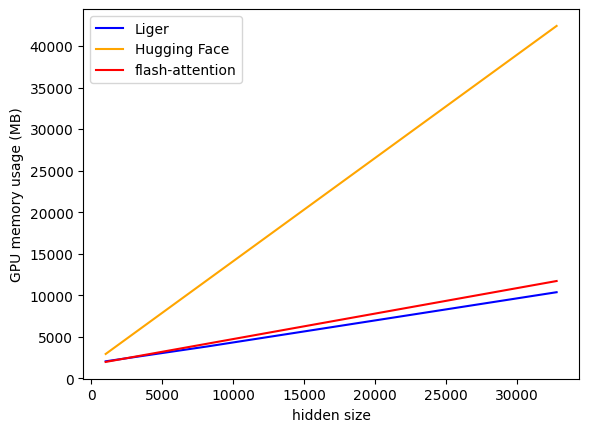

In [40]:
from typing import Callable

def _test_memory(func: Callable, _iter: int = 10) -> float:
    total_mem = []

    for _ in range(_iter):
        torch.cuda.memory.reset_peak_memory_stats()
        func()
        mem = torch.cuda.max_memory_allocated()
        total_mem.append(mem)

    return sum(total_mem) / len(total_mem)

@triton.testing.perf_report(
    [
        triton.testing.Benchmark(
            x_names=["N"],
            x_vals=[2**i for i in range(10, 16)],
            xlabel="hidden size",
            line_arg="provider",
            line_vals=["liger", "huggingface","flash-attention"],
            line_names=["Liger", "Hugging Face", "flash-attention"],
            styles=[("blue", "solid"), ("orange", "solid"), ("red", "solid")],
            ylabel="GPU memory usage (MB)",
            plot_name="rmsnorm-full-memory-benchmark",
            args={"M": 2048, "dtype": torch.bfloat16, "mode": "full"},
        )
    ]
)
def bench_memory_rms_norm(M, N, dtype, provider, mode, eps=1e-5, device="cuda"):
    x_shape = (8192*4, N)

    triton_rms = LigerRMSNorm(hidden_size=N).to("cuda")
    llama_rms = RMSNorm(hidden_size=N).to("cuda")
    triton_rmsnorm = TritonRMSNorm(hidden_size=N).to("cuda")

    x = torch.randn(x_shape, dtype=dtype, device="cuda")
    dy = torch.randn_like(x)
    x.requires_grad_(True)

    # utility functions
    def y_fwd():
        if provider == "liger":
            return triton_rms(x)
        if provider == "huggingface":
            return llama_rms(x)
        if provider == "flash-attention":
            return triton_rmsnorm(x)

    def full():
        y = y_fwd()
        y.backward(dy, retain_graph=True)

    mem = _test_memory(full)

    return mem / 2**20

bench_memory_rms_norm.run(save_path='', print_data=True)

In [42]:
# Setup
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters
seven_b_llama = True
batch_size = 4
seq_len = 8192
# d_model = 4096 if seven_b_llama else 8192
d_model = 4096
num_attention_heads = 32 if seven_b_llama else 64
num_key_values = 8
d_k = d_model // num_attention_heads

# Input tensor
# x = torch.randn(batch_size * seq_len, d_model, dtype=torch.bfloat16, device=device)
x = torch.randn(seq_len*batch_size, d_model, dtype=torch.bfloat16, device=device)

# Initialize models
triton_rmsnorm = TritonRMSNorm(d_model).to(device).to(torch.bfloat16)
rmsnorm = RMSNorm(d_model).to(device).to(torch.bfloat16)
liger_rmsnorm = LigerRMSNorm(d_model).to(device).to(torch.bfloat16)

In [43]:
n_runs = 400
# time per run
rms_t, rms_m = benchmark_forward(rmsnorm, x, repeats=n_runs, desc="", verbose=False, amp=False, amp_dtype=torch.bfloat16)
triton_t,triton_m = benchmark_forward(triton_rmsnorm, x, repeats=n_runs, desc="", verbose=False, amp=False, amp_dtype=torch.bfloat16)
liger_t, liger_m = benchmark_forward(liger_rmsnorm, x, repeats=n_runs, desc="", verbose=False, amp=False, amp_dtype=torch.bfloat16)

print("Forward pass") 
print("LLaMA RMSNorm", rms_m.mean)
print("Triton RMSNorm",triton_m.mean)
print("Liger RMSNorm", liger_m.mean)
print("Speedup: ", rms_m.mean / triton_m.mean)
print("Speedup liger/rmsnorm: ", rms_m.mean / liger_m.mean)
print("Speedup liger/triton: ", triton_m.mean / liger_m.mean)

_, rms_backward = benchmark_backward(rmsnorm, x, repeats=n_runs, desc="", verbose=False, amp=False, amp_dtype=torch.bfloat16)
_, triton_backward = benchmark_backward(triton_rmsnorm, x, repeats=n_runs, desc="", verbose=False, amp=False, amp_dtype=torch.bfloat16)
_, liger_backward = benchmark_backward(liger_rmsnorm, x, repeats=n_runs, desc="", verbose=False, amp=False, amp_dtype=torch.bfloat16)

print("\nBackward pass")
print("LLaMA RMSNorm",rms_backward.mean)
print("Triton RMSNorm",triton_backward.mean)
print("Liger RMSNorm",liger_backward.mean)
print("Speedup: ", rms_backward.mean / triton_backward.mean)
print("Speedup liger/rmsnorm: ", rms_backward.mean / liger_backward.mean)
print("Speedup liger/triton: ", triton_backward.mean / liger_backward.mean)

Forward pass
LLaMA RMSNorm 0.0021244759997352957
Triton RMSNorm 0.0001815802976489067
Liger RMSNorm 0.0001808164524845779
Speedup:  11.699925747688008
Speedup liger/rmsnorm:  11.749351182058476
Speedup liger/triton:  1.0042244229097126

Backward pass
LLaMA RMSNorm 0.00036596331221517176
Triton RMSNorm 0.0003908755100565031
Liger RMSNorm 0.0006286883301800117
Speedup:  0.9362656467330732
Speedup liger/rmsnorm:  0.5821061003476649
Speedup liger/triton:  0.6217317727920671


In [9]:
# Run benchmarks
n_runs = 400

# time_rmsnorm = benchmark(rmsnorm, x, n_runs=n_runs)
# time_triton_rmsnorm = benchmark(triton_rmsnorm, x, n_runs=n_runs)

time_triton_rmsnorm = benchmark(triton_rmsnorm, x, n_runs=n_runs, profiler_output_folder="triton_rmsnorm")
time_rmsnorm = benchmark(rmsnorm, x, n_runs=n_runs, profiler_output_folder="rmsnorm")

print(f"TritonRMSNorm time: {time_triton_rmsnorm:.6f} seconds per run")
print(f"RMSNorm time: {time_rmsnorm:.6f} seconds per run")
print(f"Speedup: {time_rmsnorm / time_triton_rmsnorm:.2f}x")

TritonRMSNorm time: 0.000694 seconds per run
RMSNorm time: 0.000458 seconds per run
Speedup: 0.66x


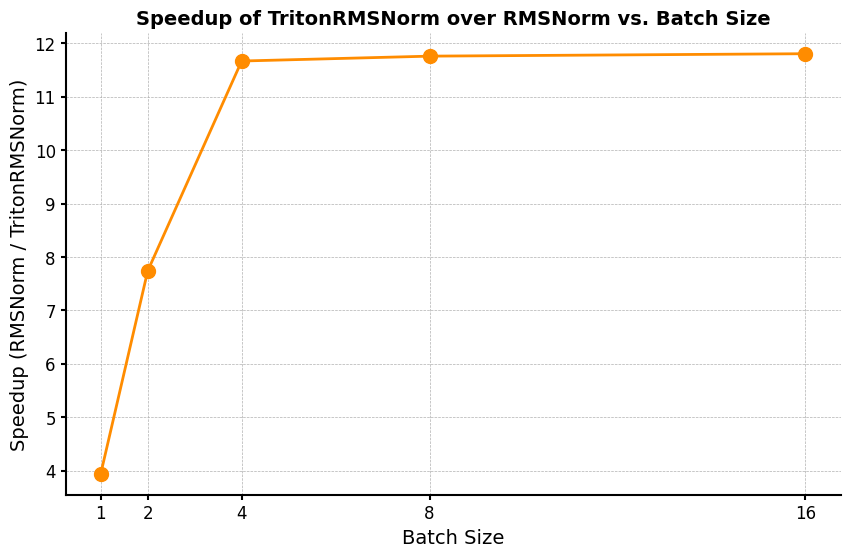

In [15]:
def benchmark_layernorm(batch_sizes):
    # Setup
    torch.manual_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    seven_b_llama = True
    # Parameters
    seq_len = 8192
    d_model = 4096 if seven_b_llama else 8192
    

    print(f"Sequence length = {seq_len}, d_model = {d_model}")
    
    # Initialize models
    triton_rmsnorm = TritonRMSNorm(d_model).to(device).bfloat16()
    rmsnorm = RMSNorm(d_model).to(device).bfloat16()
    
    speedups = []

    for batch_size in batch_sizes:
        # Input tensor
        x = torch.randn(batch_size * seq_len, d_model, dtype=torch.bfloat16, device=device)

        # Run benchmarks
        n_runs = 400

        time_triton_rmsnorm = benchmark(triton_rmsnorm, x, n_runs=n_runs)
        time_rmsnorm = benchmark(rmsnorm, x, n_runs=n_runs)
        
        speedups.append(time_rmsnorm / time_triton_rmsnorm)

        TFLOPS = 6 * batch_size * seq_len * d_model / 1e12

        print(f"batch size = {batch_size}")
        print(f"TritonRMSNorm time: {time_triton_rmsnorm:.6f} seconds per run, TFLOPS: {TFLOPS / time_triton_rmsnorm:.2f}")
        print(f"RMSNorm time: {time_rmsnorm:.6f} seconds per run, TFLOPS: {TFLOPS / time_rmsnorm:.2f}")
        print(f"Speedup: {time_rmsnorm / time_triton_rmsnorm:.2f}x")
        print(f"Time per run: {time_triton_rmsnorm:.6f}, {time_rmsnorm:.6f}")
        print(f"Time saving per run: {(time_rmsnorm - time_triton_rmsnorm)/n_runs:.6f} seconds")
        print()
        
    return speedups

batch_sizes = [1, 2, 4, 8, 16]
with RedirectOutput("../../.cache/logs/benchmark/benchmark_layernorm.txt"):
    speedups_ln = benchmark_layernorm(batch_sizes)
    
import matplotlib.pyplot as plt    

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, speedups_ln, marker='o', linestyle='-', color='darkorange', linewidth=2, markersize=10)
plt.xlabel('Batch Size', fontsize=14)
plt.ylabel('Speedup (RMSNorm / TritonRMSNorm)', fontsize=14)
plt.title('Speedup of TritonRMSNorm over RMSNorm vs. Batch Size', fontsize=14, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(batch_sizes, fontsize=12)
plt.yticks(fontsize=12)

# Adding some style to the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().tick_params(width=1.5)
plt.show()

# Flash RoPE

In [16]:
from typing import Optional
from flash_attn.layers.rotary import RotaryEmbedding as FlashRotaryEmbedding

## Copy from transformers. Non interleaved version of RoPE. Will be refactored later
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


class LlamaRotaryEmbedding(nn.Module):
    def __init__(self, dim: int, end: int, theta: float = 500000.0):
        super().__init__()
        self.dim = dim
        self.end = end
        self.theta = theta
        self.init_rotary_embeddings()

    def init_rotary_embeddings(self):
        inv_freq = 1.0 / (
            self.theta ** (torch.arange(0, self.dim, 2, dtype=torch.float, device="cpu") / self.dim)
        )  # important to compute on CPU
        # inv_freq = apply_scaling(inv_freq)  # if LLaMA 3.1
        self.register_buffer(
            "inv_freq", torch.empty(self.dim // 2, dtype=torch.float, device="cuda"), persistent=False
        )
        self.inv_freq = self.inv_freq.to(
            torch.float
        )  # make it float32 before copy to avoid precision loss during copy_
        self.inv_freq.copy_(inv_freq)

        saved_inv_freq = torch.load("/fsx/haojun/LLaMA/.cache/activation_values/inv_freq.pt")
        assert torch.equal(self.inv_freq.cpu(), saved_inv_freq), "inv_freq mismatch."

    @torch.no_grad()
    def forward(
        self,
        x: torch.Tensor,  # [batch_size, seq_length, num_heads, d_qk]
        position_ids: Optional[torch.LongTensor],  # [batch_size, seq_length]
    ):
        # x: [bs, num_attention_heads, seq_len, head_size]
        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        position_ids_expanded = position_ids[:, None, :].float()
        # Force float32 since bfloat16 loses precision on long contexts
        # See https://github.com/huggingface/transformers/pull/29285
        device_type = x.device.type
        device_type = device_type if isinstance(device_type, str) and device_type != "mps" else "cpu"
        with torch.autocast(device_type=device_type, enabled=False):
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
            emb = torch.cat((freqs, freqs), dim=-1)
            cos = emb.cos()
            sin = emb.sin()
        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)

def apply_rotary_pos_emb(q, k, cos, sin, unsqueeze_dim=2):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


# Define the benchmark function
def benchmark_rotary(rotary_embedding, apply_rotary_pos_emb, q, k, v, position_ids, n_runs=100, warm_up=20):
    # Warm-up phase
    for _ in range(warm_up):
        cos, sin = rotary_embedding(v, position_ids)
        _ = apply_rotary_pos_emb(q, k, cos, sin)
    
    # Benchmark phase
    start_event = Event(enable_timing=True)
    end_event = Event(enable_timing=True)
    
    torch.cuda.synchronize()
    start_event.record()
    
    for _ in range(n_runs):
        cos, sin = rotary_embedding(v, position_ids)
        _ = apply_rotary_pos_emb(q, k, cos, sin)
    
    end_event.record()
    torch.cuda.synchronize()
    
    # Return the average time per run in seconds
    return start_event.elapsed_time(end_event) / n_runs / 1000

# Setup
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seven_b_llama = True
batch_size = 8
seq_len = 8192
d_model = 4096 if seven_b_llama else 8192
num_attention_heads = 32 if seven_b_llama else 64
num_key_values = 8
d_k = d_model // num_attention_heads

q = torch.randn(batch_size, seq_len, num_attention_heads, d_k, dtype=torch.bfloat16, device=device)
k = torch.randn(batch_size, seq_len, num_key_values, d_k, dtype=torch.bfloat16, device=device)
v = torch.randn(batch_size, seq_len, num_key_values, d_k, dtype=torch.bfloat16, device=device)

rotary_embedding = LlamaRotaryEmbedding(dim=d_k, end=seq_len, theta=500000).to(device).bfloat16()
flash_rotary_embedding = FlashRotaryEmbedding(dim=d_k, interleaved=False, base=500000).to(device)

position_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch_size, -1)

# Benchmark Llama Rotary Embedding
time_llama_rotary_embedding = benchmark_rotary(rotary_embedding, apply_rotary_pos_emb, q, k, v, position_ids, n_runs=400)

# If you want to benchmark the FlashRotaryEmbedding as well, you can define another benchmark function or adjust the existing one.
# Here’s an example if you want to benchmark the FlashRotaryEmbedding directly:
def benchmark_flash(model, q, kv, n_runs=100, warm_up=20):
    for _ in range(warm_up):
        _ = model(q, kv)
    
    # Benchmark
    start_event = Event(enable_timing=True)
    end_event = Event(enable_timing=True)
    
    torch.cuda.synchronize()
    start_event.record()
    
    for _ in range(n_runs):
        _ = model(q, kv)
    
    end_event.record()
    torch.cuda.synchronize()
    
    return start_event.elapsed_time(end_event) / n_runs / 1000

k = k.unsqueeze(2)
v = v.unsqueeze(2)
kv = torch.cat((k, v), dim=2)

time_flash_rotary_embedding = benchmark_flash(flash_rotary_embedding, q, kv, n_runs=400)

# Print the results
print(f"LlamaRotaryEmbedding time: {time_llama_rotary_embedding:.6f} seconds per run")
print(f"FlashRotaryEmbedding time: {time_flash_rotary_embedding:.6f} seconds per run")
print(f"Speedup: {time_llama_rotary_embedding / time_flash_rotary_embedding:.2f}x")


LlamaRotaryEmbedding time: 0.004462 seconds per run
FlashRotaryEmbedding time: 0.000581 seconds per run
Speedup: 7.68x


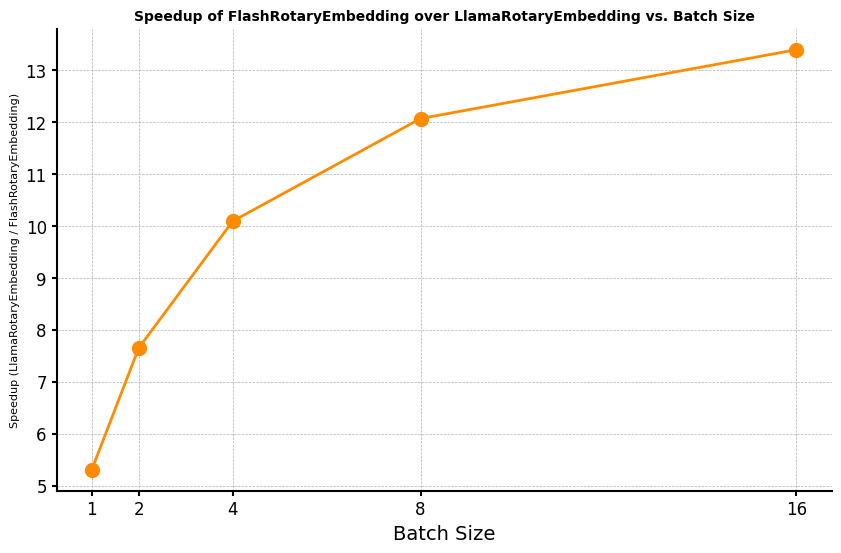

In [17]:
import torch
from torch.cuda import Event
import matplotlib.pyplot as plt

def benchmark_rope(batch_sizes):
    # Setup
    torch.manual_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    seven_b_llama = True
    seq_len = 8192
    d_model = 4096 if seven_b_llama else 8192
    num_attention_heads = 32 if seven_b_llama else 64
    d_k = d_model // num_attention_heads

    print(f"Sequence length = {seq_len}, d_model = {d_model}")
    
    # Initialize rotary embeddings
    rotary_embedding = LlamaRotaryEmbedding(dim=d_k, end=seq_len, theta=500000).to(device).bfloat16()
    flash_rotary_embedding = FlashRotaryEmbedding(dim=d_k, interleaved=False, base=500000).to(device)
    
    speedups = []

    for batch_size in batch_sizes:
        # Generate input tensors
        q = torch.randn(batch_size, seq_len, num_attention_heads, d_k, dtype=torch.bfloat16, device=device)
        k = torch.randn(batch_size, seq_len, num_attention_heads, d_k, dtype=torch.bfloat16, device=device)
        v = torch.randn(batch_size, seq_len, num_attention_heads, d_k, dtype=torch.bfloat16, device=device)
        position_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch_size, -1)

        # Run benchmarks
        n_runs = 400

        time_llama_rotary = benchmark_rotary(rotary_embedding, apply_rotary_pos_emb, q, k, v, position_ids, n_runs=n_runs)
        time_flash_rotary = benchmark_flash(flash_rotary_embedding, q, kv, n_runs=n_runs)
        
        speedups.append(time_llama_rotary / time_flash_rotary)

        TFLOPS = 6 * batch_size * seq_len * d_model / 1e12

        print(f"Batch size = {batch_size}")
        print(f"LlamaRotaryEmbedding time: {time_llama_rotary:.6f} seconds per run, TFLOPS: {TFLOPS / time_llama_rotary:.2f}")
        print(f"FlashRotaryEmbedding time: {time_flash_rotary:.6f} seconds per run, TFLOPS: {TFLOPS / time_flash_rotary:.2f}")
        print(f"Speedup: {time_llama_rotary / time_flash_rotary:.2f}x")
        print(f"Time per run: {time_llama_rotary:.6f}, {time_flash_rotary:.6f}")
        print(f"Time saving per run: {(time_llama_rotary - time_flash_rotary)/n_runs:.6f} seconds")
        print()
        
    return speedups

batch_sizes = [1, 2, 4, 8, 16]

with RedirectOutput("../../.cache/logs/benchmark/benchmark_rope.txt"):
    speedups_rope = benchmark_rope(batch_sizes)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, speedups_rope, marker='o', linestyle='-', color='darkorange', linewidth=2, markersize=10)
plt.xlabel('Batch Size', fontsize=14)
plt.ylabel('Speedup (LlamaRotaryEmbedding / FlashRotaryEmbedding)', fontsize=8)
plt.title('Speedup of FlashRotaryEmbedding over LlamaRotaryEmbedding vs. Batch Size', fontsize=10, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(batch_sizes, fontsize=12)
plt.yticks(fontsize=12)

# Adding some style to the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().tick_params(width=1.5)
plt.show()

# Plot everything together

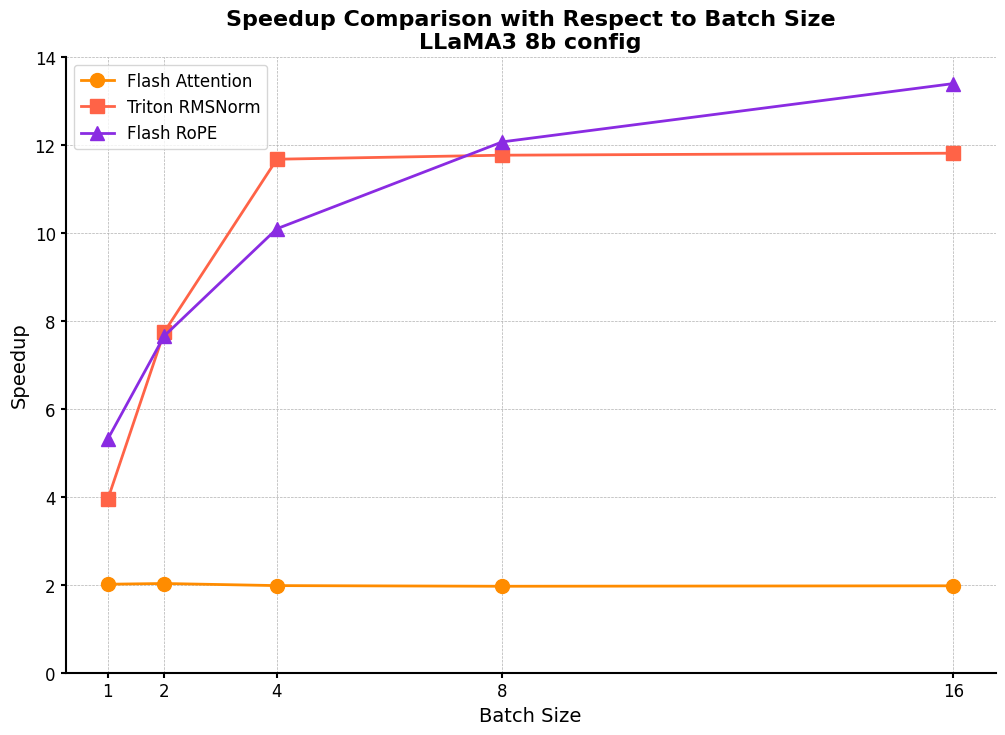

In [27]:
# Plotting all three benchmarks in one graph with improved colors and styling
plt.figure(figsize=(12, 8))

# Plot for QKV
# plt.plot(batch_sizes, speedups_qkv, marker='o', linestyle='-', color='darkorange', linewidth=2, markersize=10, label='QKV projection')  # Using DarkOrange color

# Plot for Flash attention 
plt.plot(batch_sizes, speedup_flash, marker='o', linestyle='-', color='darkorange', linewidth=2, markersize=10, label='Flash Attention')  # Using DarkOrange color

# Plot for LayerNorm
plt.plot(batch_sizes, speedups_ln, marker='s', linestyle='-', color='#FF6347', linewidth=2, markersize=10, label='Triton RMSNorm')  # Using Tomato color

# Plot for RoPE
plt.plot(batch_sizes, speedups_rope, marker='^', linestyle='-', color='#8A2BE2', linewidth=2, markersize=10, label='Flash RoPE')  # Using BlueViolet color

# Adding labels, title, and legend
plt.xlabel('Batch Size', fontsize=14)
plt.ylabel('Speedup', fontsize=14)
plt.title('Speedup Comparison with Respect to Batch Size\nLLaMA3 8b config', fontsize=16, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(batch_sizes, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 14)

# Adding some style to the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().tick_params(width=1.5)

# Adding legend
plt.legend(fontsize=12)

# Display the plot
plt.show()


## Benchmark model

In [20]:
import sys
import time
from src.model.llama3 import LLaMA
from tools.debug.logs import log_model_num_params
import torch 
from dataclasses import dataclass
from src.weights.weights import load_weights_to_dict, copy_weights_to_model
from transformers import AutoTokenizer
import os
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from src.data.data import tokenize_dataset, get_dataloader


# to match the output of transformers model, set MERGED_QKV_WEIGHT to 0 is necessary
os.environ['DATA_TYPE'] = 'bfloat16' # bfloat16/float32
os.environ['MERGED_QKV_WEIGHT'] = '0' # 1/0
os.environ['MERGED_GATE_UP_WEIGHT'] = '0' # 1/0
os.environ['TRITONRMSNORM'] = '0'
os.environ['FLASH_ROPE'] = '0'
os.environ['ATTENTION'] = 'FLASH' # SDPA/FLASH
os.environ['USE_PROFILER'] = '0' # 1/0

# set device and dtype
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.bfloat16 if os.getenv('DATA_TYPE', 'bfloat16') == 'bfloat16' else torch.float32

# Set the seed for reproducibility
seed = 42
torch.manual_seed(seed)

## Initialize model, loss function, and optimizer
## GPT2 base model
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
sequence_length = 1024
@dataclass
class LLaMAConfig:
    batch_size: int = 1
    max_position_embeddings: int = sequence_length
    hidden_dim: int = 768
    intermediate_dim: int = 3072
    vocab_size = 50304 #  https://x.com/karpathy/status/1621578354024677377 still true.  50304 ~30% speedup
    num_key_values: int = 12
    num_heads: int = 12
    num_layers: int = 12
    rope_theta: float = 500000.0
    torch_dtype: str = 'bfloat16'
    rms_norm_eps: float = 1e-5

dataset = load_dataset("roneneldan/TinyStories", split='train')
tokenized_dataset = tokenize_dataset(dataset, tokenizer, text_column_name = 'text', sequence_length = sequence_length, dataset_processing_num_proc_per_process = 64)

# DataLoader
batch_size = 8
# shuffle = False
# dataloader = get_dataloader(tokenized_dataset, batch_size, shuffle)

config = LLaMAConfig()
slow_model = LLaMA(config).to(dtype).to(device)

os.environ['TRITONRMSNORM'] = '1'
os.environ['FLASH_ROPE'] = '1'

fast_model = LLaMA(config).to(dtype).to(device)

/fsx/haojun/transformers/src/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [25]:
input = torch.randint(0, config.vocab_size, (batch_size, sequence_length), dtype=torch.long).to(device)
time_slow = benchmark(slow_model, input, n_runs=n_runs)
time_fast = benchmark(fast_model, input, n_runs=n_runs)

In [26]:
print(f"Slow model time: {time_slow:.6f} seconds per run")
print(f"Fast model time: {time_fast:.6f} seconds per run")
print(f"Speedup: {time_slow / time_fast:.2f}x")

Slow model time: 0.016697 seconds per run
Fast model time: 0.017167 seconds per run
Speedup: 0.97x


no speedup here, because the model is too small.

# Reproduce difference 

## MM 

In [20]:
import torch

torch.manual_seed(42)
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the dtype to bfloat16
dtype = torch.bfloat16

sequence_length = 8192 
d_model = 4096
d_q = 4096
d_kv = 512

# Create random matrices A, B, and C
A = torch.randn((sequence_length, d_model), device=device, dtype=torch.bfloat16)
B = torch.randn((d_model, d_q), device=device, dtype=torch.bfloat16)
C = torch.randn((d_model, d_kv), device=device, dtype=torch.bfloat16)

# Compute [B; C] (stacking matrices B and C vertically)
BC = torch.cat((B, C), dim=1)

# Compute A * [B; C]
result1 = A @ BC

# Compute A * B and A * C separately, then stack the results
result2_B = A @ B
result2_C = A @ C
result2 = torch.cat((result2_B, result2_C), dim=1)

# Number of different elements 
num_diff = torch.sum(result1 != result2)

# Calculate the difference between the two results
difference = torch.abs(result1 - result2)

# Check the maximum difference to see the numerical error
max_difference = torch.max(difference)

# Print the result
print("Number of different elements between A * [B; C] and [A * B; A * C]:", num_diff.item())
print(f"Max difference between A * [B; C] and [A * B; A * C]: {max_difference.item()}")
torch.testing.assert_close(result1, result2, rtol=1e-5, atol=1e-5)

Number of different elements between A * [B; C] and [A * B; A * C]: 1082
Max difference between A * [B; C] and [A * B; A * C]: 1.0


AssertionError: Tensor-likes are not close!

Mismatched elements: 1082 / 37748736 (0.0%)
Greatest absolute difference: 1.0 at index (7379, 3622) (up to 1e-05 allowed)
Greatest relative difference: 0.212890625 at index (7829, 4063) (up to 1e-05 allowed)

## RoPE

In [26]:
base = 500000
head_dim = 128
my_theta_cpu = 1.0 / (base ** (torch.arange(0, head_dim, 2, dtype=torch.int64).float().to('cpu') / head_dim)) 
my_theta_gpu = 1.0 / (base ** (torch.arange(0, head_dim, 2, dtype=torch.int64).float().to('cuda') / head_dim)) 
torch.eq(my_theta_cpu, my_theta_gpu.cpu())

tensor([ True,  True,  True,  True,  True,  True, False,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True,  True,  True])

: 

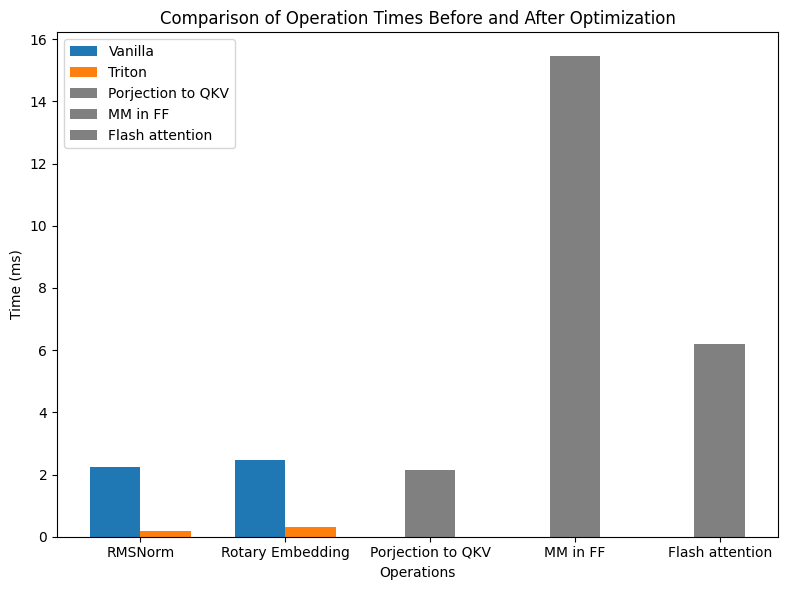

In [17]:
import matplotlib.pyplot as plt

# Updated data for the bar graph
labels_updated = [
    'RMSNorm', 
    'Apply Rotary Embedding'
]

before_change_updated = [
    2.252, 
    2.47
]

after_change_updated = [
    0.177, 
    0.307
]

# Plotting the updated bar graph
x_updated = range(len(labels_updated))

# Plotting the updated bar graph with only one bar for unchanged operations

# Plotting the updated bar graph with separated bars for before/after changes
plt.figure(figsize=(8, 6))
width = 0.35  # the width of the bars

# Original operations
plt.bar(x_updated, before_change_updated, width, label='Vanilla')

# Optimized operations
plt.bar([i + width for i in x_updated], after_change_updated, width, label='Triton')

# Adding only one bar for unchanged operations (centered in its own position)
plt.bar([2 + width/2], [2.15], width, color='gray', label='Porjection to QKV')
plt.bar([3 + width/2], [5.149*3], width, color='gray', label='MM in FF')
plt.bar([4 + width/2], [6.2], width, color='gray', label='Flash attention')

plt.xlabel('Operations')
plt.ylabel('Time (ms)')
plt.title('Comparison of Operation Times Before and After Optimization')
plt.xticks([0 + width/2, 1 + width/2, 2 + width/2, 3 + width/2, 4 + width/2], ['RMSNorm', 'Rotary Embedding', 'Porjection to QKV', 'MM in FF', 'Flash attention'])
plt.legend()

plt.tight_layout()
plt.show()



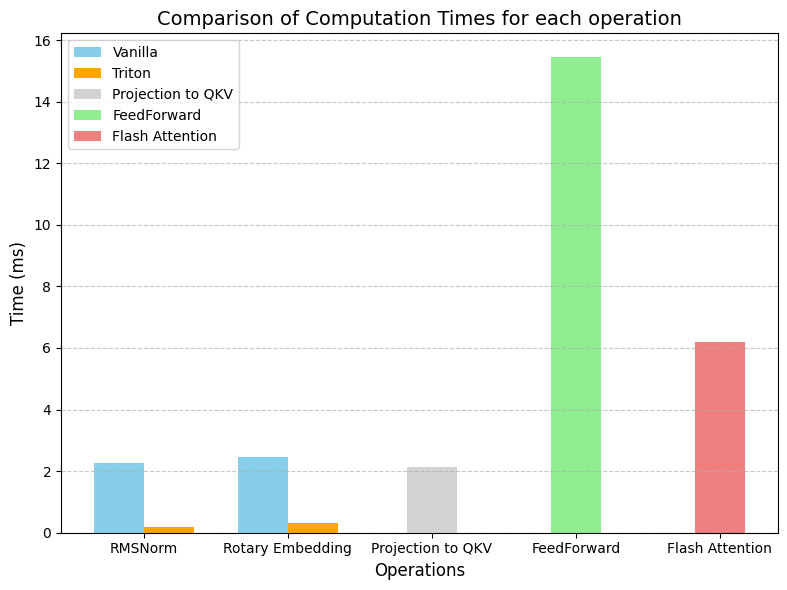

In [26]:
import matplotlib.pyplot as plt

# Updated data for the bar graph
labels_updated = [
    'RMSNorm', 
    'Apply Rotary Embedding'
]

before_change_updated = [
    2.252, 
    2.47
]

after_change_updated = [
    0.177, 
    0.307
]

# Plotting the updated bar graph
x_updated = range(len(labels_updated))

# Plotting the updated bar graph with separated bars for before/after changes
plt.figure(figsize=(8, 6))
width = 0.35  # the width of the bars

# Original operations
plt.bar(x_updated, before_change_updated, width, label='Vanilla', color='skyblue')

# Optimized operations
plt.bar([i + width for i in x_updated], after_change_updated, width, label='Triton', color='orange')

# Adding only one bar for unchanged operations (centered in its own position)
plt.bar([2 + width/2], [2.15], width, color='lightgray', label='Projection to QKV')
plt.bar([3 + width/2], [5.149*3], width, color='lightgreen', label='FeedForward')
plt.bar([4 + width/2], [6.2], width, color='lightcoral', label='Flash Attention')

# Enhancing the appearance of the graph
plt.xlabel('Operations', fontsize=12)
plt.ylabel('Time (ms)', fontsize=12)
plt.title('Comparison of Computation Times for each operation', fontsize=14)
plt.xticks([0 + width/2, 1 + width/2, 2 + width/2, 3 + width/2, 4 + width/2], 
           ['RMSNorm', 'Rotary Embedding', 'Projection to QKV', 'FeedForward', 'Flash Attention'], 
           fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
